In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

# !pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree

import shap

In [2]:
# 1. read CSV
df = pd.read_csv('/content/drive/MyDrive/XAI_DATA/Combined.csv',encoding='utf-8')

# 2. show the sample data
print("data sample：")
print(df.head())

# 3. basic info
print("\nbasic info：")
print(df.describe(include='all'))

# handle NaN
print(df.info())
MIN_NON_NULL=1215000
df_cleaned = df.dropna(axis=1, thresh=MIN_NON_NULL)
print(df_cleaned.info())

# object
object_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print(f"Object（{len(object_cols)}）：\n{object_cols}")

analysis_report = pd.DataFrame({
        'column': object_cols,
        'unique': [df[col].nunique() for col in object_cols],
        'Nan': [df[col].isnull().sum() for col in object_cols],
        'Nan rate': [df[col].isnull().mean().round(4) for col in object_cols],
        'frequency': [df[col].mode()[0] if not df[col].empty else np.nan for col in object_cols],
        'frequency rate': [round(df[col].value_counts(normalize=True).iloc[0], 4) for col in object_cols],
        'sample': [df[col].dropna().iloc[0] if not df[col].dropna().empty else np.nan for col in object_cols]
})

print("\nObject：")
display(analysis_report.sort_values('unique', ascending=False))

for col in object_cols:
    value_counts = df[col].value_counts(dropna=False)
    unique_count = len(value_counts)

    print(f"\n=== column【{col}】 ===")
    print(f"unique{unique_count}")
    print(value_counts.head(20))

<ipython-input-2-3788024690>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/XAI_DATA/Combined.csv',encoding='utf-8')


data sample：
   Unnamed: 0  Seq       Dur   RunTime      Mean       Sum       Min  \
0           0    1  0.000000  0.000000  0.000000  0.000000  0.000000   
1           1    2  0.000000  0.000000  0.000000  0.000000  0.000000   
2           2    3  4.998020  4.998020  4.998020  4.998020  4.998020   
3           3    4  4.998037  4.998037  4.998037  4.998037  4.998037   
4           4    5  4.999453  4.999453  4.999453  4.999453  4.999453   

        Max Proto  sTos  ...  sVid dVid SrcTCPBase  DstTCPBase  TcpRtt  \
0  0.000000  icmp   0.0  ...   NaN  NaN        NaN         NaN     0.0   
1  0.000000  icmp   0.0  ...   NaN  NaN        NaN         NaN     0.0   
2  4.998020   udp   0.0  ...   NaN  NaN        NaN         NaN     0.0   
3  4.998037   udp   0.0  ...   NaN  NaN        NaN         NaN     0.0   
4  4.999453   udp   0.0  ...   NaN  NaN        NaN         NaN     0.0   

   SynAck  AckDat   Label  Attack Type  Attack Tool  
0     0.0     0.0  Benign       Benign       Benign  
1

,column,unique,Nan,Nan rate,frequency,frequency rate,sample
1,sDSb,12,214,0.0002,cs0,0.9947,cs0
3,State,11,0,0.0000,REQ,0.4847,ECO
5,Attack Type,9,0,0.0000,Benign,0.3929,Benign
0,Proto,8,0,0.0000,udp,0.7427,icmp
6,Attack Tool,6,0,0.0000,Benign,0.3929,Benign
2,Cause,3,0,0.0000,Status,0.5993,Start
4,Label,2,0,0.0000,Malicious,0.6071,Benign



=== column【Proto】 ===
unique8
Proto
udp          903040
tcp          278671
icmp          29636
sctp           4327
lldp            115
llc              58
arp              41
ipv6-icmp         2
Name: count, dtype: int64

=== column【sDSb】 ===
unique13
sDSb
cs0     1209216
ef         3538
af11        789
cs6         640
cs7         528
af41        515
NaN         214
52          144
af12        137
cs4          93
4            74
39            1
54            1
Name: count, dtype: int64

=== column【Cause】 ===
unique3
Cause
Status      728665
Start       486523
Shutdown       702
Name: count, dtype: int64

=== column【State】 ===
unique11
State
REQ    589299
INT    328746
CON    132174
RST     75670
FIN     59181
ECO     28822
ACC      1109
URP       786
RSP        73
TST        28
NRS         2
Name: count, dtype: int64

=== column【Label】 ===
unique2
Label
Malicious    738153
Benign       477737
Name: count, dtype: int64

=== column【Attack Type】 ===
unique9
Attack Type
Benign           

In [3]:
# data processing
# merge some categories
df_cleaned['Proto'] = np.where(df_cleaned['Proto'].isin(['lldp','llc','arp','ipv6-icmp']), 'other', df_cleaned['Proto'])
df_cleaned['State'] = np.where(df_cleaned['State'].isin(['ECO','ACC','URP','RSP','TST','NRS']), 'other', df_cleaned['State'])

# # encode
# proto_freq = df['Proto'].value_counts(normalize=True)
# df['Proto_encoded'] = df['Proto'].map(proto_freq)
proto_dummies = pd.get_dummies(df_cleaned['Proto'], prefix='Proto')
cause_dummies = pd.get_dummies(df_cleaned['Cause'], prefix='Cause')
state_dummies = pd.get_dummies(df_cleaned['State'], prefix='State')
df_new = pd.concat([df_cleaned, proto_dummies, cause_dummies,state_dummies], axis=1)
df_new.drop(['Proto', 'Cause','State','sDSb'], axis=1, inplace=True)
df_new=df_new.dropna(axis=0)
print(df_new.info())

<ipython-input-3-2931258636>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Proto'] = np.where(df_cleaned['Proto'].isin(['lldp','llc','arp','ipv6-icmp']), 'other', df_cleaned['Proto'])
<ipython-input-3-2931258636>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['State'] = np.where(df_cleaned['State'].isin(['ECO','ACC','URP','RSP','TST','NRS']), 'other', df_cleaned['State'])


<class 'pandas.core.frame.DataFrame'>
Index: 1215676 entries, 0 to 1215889
Data columns (total 50 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unnamed: 0      1215676 non-null  int64  
 1   Seq             1215676 non-null  int64  
 2   Dur             1215676 non-null  float64
 3   RunTime         1215676 non-null  float64
 4   Mean            1215676 non-null  float64
 5   Sum             1215676 non-null  float64
 6   Min             1215676 non-null  float64
 7   Max             1215676 non-null  float64
 8   sTos            1215676 non-null  float64
 9   sTtl            1215676 non-null  float64
 10  sHops           1215676 non-null  float64
 11  TotPkts         1215676 non-null  int64  
 12  SrcPkts         1215676 non-null  int64  
 13  DstPkts         1215676 non-null  int64  
 14  TotBytes        1215676 non-null  int64  
 15  SrcBytes        1215676 non-null  int64  
 16  DstBytes        1215676 non-null  int64  

In [4]:
features=df_new.columns.tolist()
features.remove('Label')
features.remove('Attack Type')
features.remove('Attack Tool')
features.remove('Unnamed: 0')
print(features)
X = df_new[features]
le = LabelEncoder()
y = df_new['Label']
y = le.fit_transform(y)

['Seq', 'Dur', 'RunTime', 'Mean', 'Sum', 'Min', 'Max', 'sTos', 'sTtl', 'sHops', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'Rate', 'SrcRate', 'DstRate', 'TcpRtt', 'SynAck', 'AckDat', 'Proto_icmp', 'Proto_other', 'Proto_sctp', 'Proto_tcp', 'Proto_udp', 'Cause_Shutdown', 'Cause_Start', 'Cause_Status', 'State_CON', 'State_FIN', 'State_INT', 'State_REQ', 'State_RST', 'State_other']


In [5]:
label_counts = df_new['Label'].value_counts()
print(label_counts)

Label
Malicious    738153
Benign       477523
Name: count, dtype: int64


In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

class XAIAnalyzer:
    """
    XAI可解释性分析器，集成SHAP和LIME功能
    """

    def __init__(self, model, X_train: pd.DataFrame, class_names: List[str] = None):
        """
        初始化XAI分析器

        Args:
            model: 训练好的机器学习模型
            X_train: 训练数据特征
            class_names: 类别名称列表
        """
        self.model = model
        self.X_train = X_train
        self.class_names = class_names or [f'Class_{i}' for i in range(2)]
        self.explainer = None
        self.lime_explainer = None

    def _create_shap_explainer(self, sample_size: int = 100):
        """创建SHAP解释器"""
        if self.explainer is None:
            sample_data = shap.sample(self.X_train, min(sample_size, len(self.X_train)))
            self.explainer = shap.KernelExplainer(self.model.predict, sample_data)
        return self.explainer

    def _create_lime_explainer(self):
        """创建LIME解释器"""
        if self.lime_explainer is None:
            self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=self.X_train.values,
                feature_names=self.X_train.columns.tolist(),
                class_names=self.class_names,
                mode='classification'
            )
        return self.lime_explainer

    def generate_shap_summary_plots(self, X_test: pd.DataFrame, max_samples: int = 1000):
        """
        生成SHAP总体分析图（bar plot和beeswarm plot）

        Args:
            X_test: 测试数据
            max_samples: 最大样本数量
        """
        print("正在生成SHAP总体分析图...")

        # 创建解释器
        explainer = self._create_shap_explainer()

        # 限制样本数量以提高性能
        test_sample = X_test.iloc[:min(max_samples, len(X_test))]

        # 计算SHAP值
        print(f"正在计算 {len(test_sample)} 个样本的SHAP值...")
        shap_values = explainer.shap_values(test_sample)

        # 生成summary plot - bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_sample, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Bar Plot)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # 生成summary plot - beeswarm plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_sample, show=False)
        plt.title("SHAP Feature Effects (Beeswarm Plot)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        return shap_values

    def find_wrong_predictions(self, X_test: pd.DataFrame, y_test: pd.Series) -> Tuple[np.ndarray, np.ndarray]:
        """
        找出模型的错误预测

        Args:
            X_test: 测试特征
            y_test: 测试标签

        Returns:
            wrong_indices: 错误预测的索引
            y_pred: 所有预测结果
        """
        print("正在分析模型预测结果...")

        y_pred = self.model.predict(X_test)
        wrong_indices = np.where(y_pred != y_test)[0]

        print(f"总样本数: {len(y_test)}")
        print(f"错误预测数: {len(wrong_indices)}")
        print(f"错误率: {len(wrong_indices)/len(y_test):.2%}")

        if len(wrong_indices) > 0:
            print(f"错误预测样本索引: {wrong_indices[:10]}..." if len(wrong_indices) > 10 else f"错误预测样本索引: {wrong_indices}")

        return wrong_indices, y_pred

    def analyze_wrong_predictions_shap(self, X_test: pd.DataFrame, y_test: pd.Series,
                                     max_samples: int = 5, class_index: Optional[int] = None):
        """
        使用SHAP分析错误预测样本

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_samples: 分析的最大样本数
            class_index: 指定分析的类别索引（多分类时使用）
        """
        wrong_indices, y_pred = self.find_wrong_predictions(X_test, y_test)

        if len(wrong_indices) == 0:
            print("🎉 模型没有错误预测！")
            return

        print(f"\n📊 正在分析前 {min(max_samples, len(wrong_indices))} 个错误预测样本的SHAP解释...")

        # 创建解释器
        explainer = self._create_shap_explainer()

        # 选择要分析的样本
        sample_indices = wrong_indices[:max_samples] if len(wrong_indices) > max_samples else wrong_indices
        X_wrong = X_test.iloc[sample_indices]

        # 计算SHAP值
        shap_values = explainer.shap_values(X_wrong)

        # 为每个错误样本生成waterfall图
        for i, idx in enumerate(sample_indices):
            self._plot_single_shap_waterfall(explainer, shap_values, X_test, y_test,
                                           y_pred, idx, i, class_index)

    def _plot_single_shap_waterfall(self, explainer, shap_values, X_test, y_test,
                                  y_pred, idx, i, class_index):
        """绘制单个样本的SHAP waterfall图"""
        print(f"\n样本 {idx}:")
        print(f"真实标签: {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]} ({self.class_names[y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]]})")
        print(f"预测标签: {y_pred[idx]} ({self.class_names[y_pred[idx]]})")

        # 处理多分类和二分类情况
        if isinstance(shap_values, list):
            # 多分类模型
            target_class = class_index if class_index is not None else y_pred[idx]
            values = shap_values[target_class][i]
            base_value = explainer.expected_value[target_class]
            plot_title = f"样本 {idx} - {self.class_names[target_class]} 类别的SHAP解释"
        else:
            # 二分类模型
            values = shap_values[i]
            base_value = explainer.expected_value
            plot_title = f"样本 {idx} - SHAP解释"

        # 创建解释对象
        explanation = shap.Explanation(
            values=values,
            base_values=base_value,
            data=X_test.iloc[idx],
            feature_names=X_test.columns.tolist()
        )

        # 绘制waterfall图
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(explanation, show=False)
        plt.title(plot_title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

    def analyze_wrong_predictions_lime(self, X_test: pd.DataFrame, y_test: pd.Series,
                                     max_samples: int = 5, num_features: int = 10):
        """
        使用LIME分析错误预测样本

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_samples: 分析的最大样本数
            num_features: LIME解释中显示的特征数量
        """
        wrong_indices, y_pred = self.find_wrong_predictions(X_test, y_test)

        if len(wrong_indices) == 0:
            print("🎉 模型没有错误预测！")
            return

        print(f"\n🔍 正在分析前 {min(max_samples, len(wrong_indices))} 个错误预测样本的LIME解释...")

        # 创建LIME解释器
        lime_explainer = self._create_lime_explainer()

        # 选择要分析的样本
        sample_indices = wrong_indices[:max_samples] if len(wrong_indices) > max_samples else wrong_indices

        # 为每个错误样本生成LIME解释
        for idx in sample_indices:
            print(f"\n--- 样本 {idx} 的LIME解释 ---")
            print(f"真实标签: {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]} ({self.class_names[y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]]})")
            print(f"预测标签: {y_pred[idx]} ({self.class_names[y_pred[idx]]})")

            # 检查模型是否有predict_proba方法
            if hasattr(self.model, 'predict_proba'):
                prediction_fn = self.model.predict_proba
            else:
                # 如果没有predict_proba，创建一个包装函数
                def prediction_fn(X):
                    preds = self.model.predict(X)
                    # 转换为概率格式（简单的one-hot编码）
                    proba = np.zeros((len(preds), len(self.class_names)))
                    for i, pred in enumerate(preds):
                        proba[i, pred] = 1.0
                    return proba

            try:
                # 生成LIME解释
                exp = lime_explainer.explain_instance(
                    X_test.iloc[idx].values,
                    prediction_fn,
                    num_features=min(num_features, len(X_test.columns))
                )

                # 显示解释
                exp.show_in_notebook(show_table=True)

                # 也可以保存为图片（可选）
                # fig = exp.as_pyplot_figure()
                # plt.title(f'LIME解释 - 样本 {idx}')
                # plt.tight_layout()
                # plt.show()

            except Exception as e:
                print(f"生成样本 {idx} 的LIME解释时出错: {str(e)}")

    def complete_xai_analysis(self, X_test: pd.DataFrame, y_test: pd.Series,
                            max_summary_samples: int = 1000, max_wrong_samples: int = 5,
                            lime_features: int = 10, class_index: Optional[int] = None):
        """
        完整的XAI分析流程

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_summary_samples: 生成总体图的最大样本数
            max_wrong_samples: 分析错误预测的最大样本数
            lime_features: LIME解释显示的特征数
            class_index: 多分类时指定分析的类别
        """
        print("🚀 开始完整的XAI可解释性分析...")
        print("=" * 60)

        # 1. 生成SHAP总体分析图
        print("📈 第一步: 生成SHAP总体分析图")
        self.generate_shap_summary_plots(X_test, max_summary_samples)

        print("\n" + "=" * 60)

        # 2. 分析错误预测 - SHAP
        print("🔍 第二步: 使用SHAP分析错误预测")
        self.analyze_wrong_predictions_shap(X_test, y_test, max_wrong_samples, class_index)

        print("\n" + "=" * 60)

        # 3. 分析错误预测 - LIME
        print("🔍 第三步: 使用LIME分析错误预测")
        self.analyze_wrong_predictions_lime(X_test, y_test, max_wrong_samples, lime_features)

        print("\n" + "=" * 60)
        print("✅ XAI分析完成！")



After having a total view of the dataset, the next step will be using different ML model to build the detection system.
Here we choose different models:

1.   Decision Trees
2.   Random Forests

1.   Multilayer Perceptron
2.   DNN

1.   XGBoost
2.   BiLSTM








train：
accuracy：1.0000
precision：1.0000
recall：1.0000
F1：1.0000
AUC：1.0000


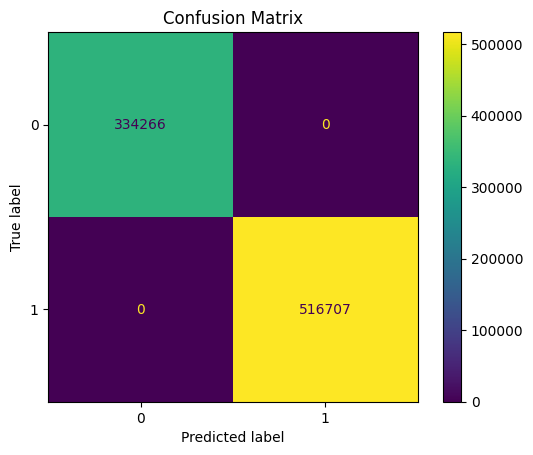


test：
accuracy：0.9996
precision：0.9997
recall：0.9997
F1：0.9997
AUC：0.9996


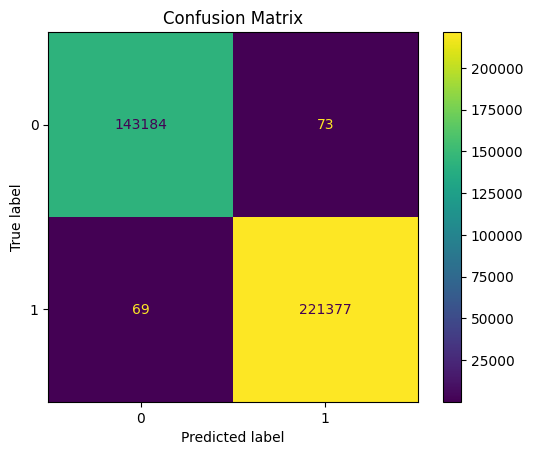

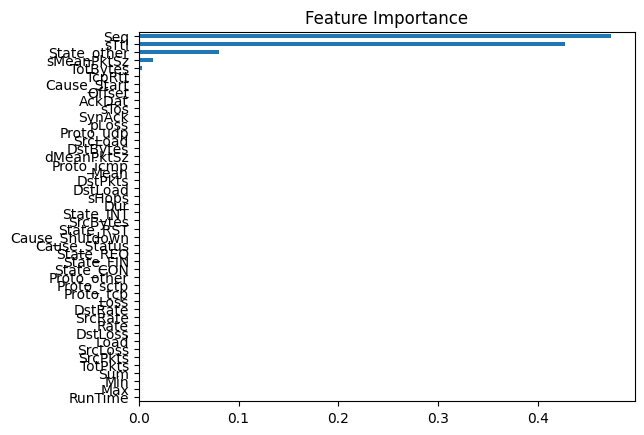

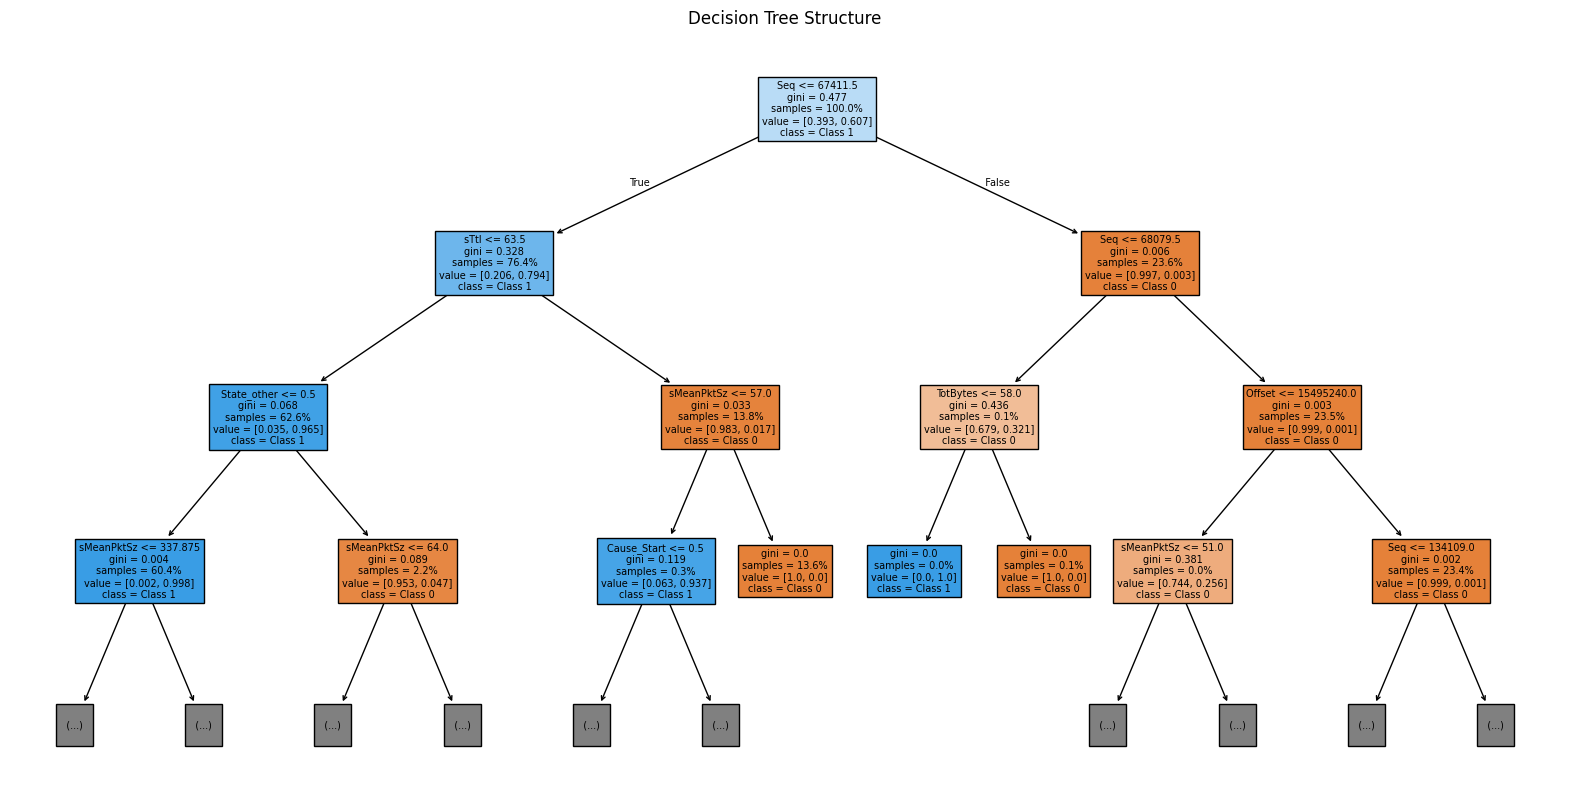

In [ ]:
#DT
# divide data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


dt = DecisionTreeClassifier(random_state=42)

## grid search
# param_grid = {
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': [None, 'balanced']
# }

# grid_search = GridSearchCV(
#     estimator=dt,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=5,
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

# best_dt = grid_search.best_estimator_
# print(f"best paras：{grid_search.best_params_}")
# print(f"best AUC：{grid_search.best_score_:.4f}")

best_dt=dt.fit(X_train, y_train)

# model eval
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"accuracy：{accuracy_score(y, y_pred):.4f}")
    print(f"precision：{precision_score(y, y_pred):.4f}")
    print(f"recall：{recall_score(y, y_pred):.4f}")
    print(f"F1：{f1_score(y, y_pred):.4f}")
    print(f"AUC：{roc_auc_score(y, y_proba):.4f}")

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

print("\ntrain：")
evaluate_model(best_dt, X_train, y_train)

print("\ntest：")
evaluate_model(best_dt, X_test, y_test)

# feature importance
feature_importance = pd.Series(best_dt.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

# plot
plt.figure(figsize=(20, 10))
from sklearn.tree import plot_tree
plot_tree(
    best_dt,
    feature_names=features,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    proportion=True,
    max_depth=3
)
plt.title('Decision Tree Structure')
plt.show()


In [ ]:
# 使用示例
# 1. 创建分析器
analyzer = XAIAnalyzer(best_dt, X_train, class_names=le.classes_.tolist())

# 2. 执行完整分析（推荐）
analyzer.complete_xai_analysis(X_test, y_test)


Output hidden; open in https://colab.research.google.com to view.

Accuracy: 1.00
Confusion Matrix:
 [[143247     10]
 [    77 221369]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    143257
           1       1.00      1.00      1.00    221446

    accuracy                           1.00    364703
   macro avg       1.00      1.00      1.00    364703
weighted avg       1.00      1.00      1.00    364703



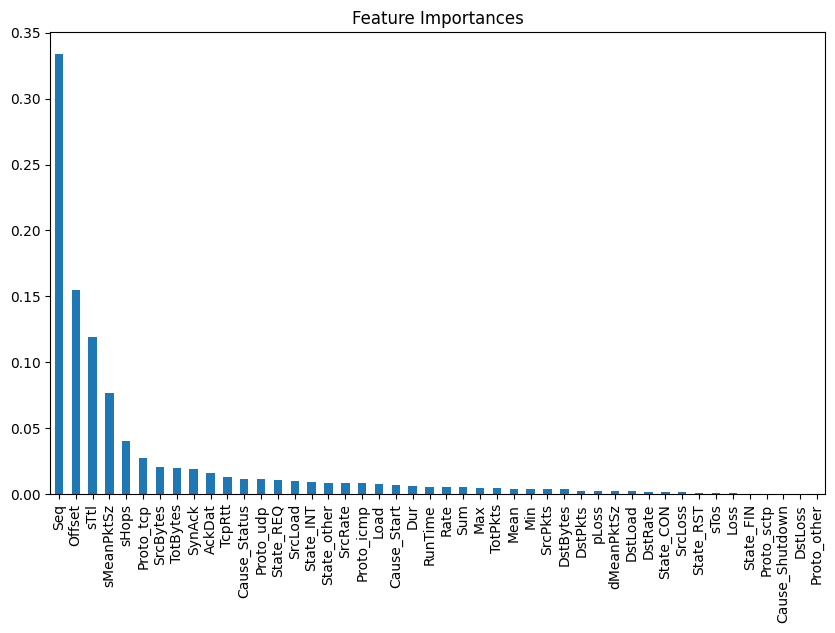

In [ ]:
#RF

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# train
rf_classifier.fit(X_train, y_train)

# prediction
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Classification Report:\n", classification_report(y_test, y_pred))

#feature importance
feature_importances = pd.Series(
    rf_classifier.feature_importances_,  # or rf_regressor
    index=X.columns
)
feature_importances = feature_importances.sort_values(ascending=False)

# plot
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importances")
plt.show()

In [ ]:
# 1. 创建分析器
analyzer = XAIAnalyzer(rf_classifier, X_train, class_names=le.classes_.tolist())

# 2. 执行完整分析（推荐）
analyzer.complete_xai_analysis(X_test, y_test)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#MLP
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# train
mlp_clf.fit(X_train, y_train)
# mlp_reg.fit(X_train, y_train)

# classification report
y_pred = mlp_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7129445055291566
Confusion Matrix:
 [[108969  34288]
 [ 70402 151044]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.76      0.68    143257
           1       0.81      0.68      0.74    221446

    accuracy                           0.71    364703
   macro avg       0.71      0.72      0.71    364703
weighted avg       0.73      0.71      0.72    364703



In [17]:
# 1. 创建分析器
analyzer = XAIAnalyzer(mlp_clf, X_train, class_names=le.classes_.tolist())

# 2. 执行完整分析（推荐）
analyzer.complete_xai_analysis(X_test, y_test)

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9834 - loss: 0.0484 - val_accuracy: 0.9963 - val_loss: 0.0086
Epoch 2/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.9978 - loss: 0.0062 - val_accuracy: 0.9990 - val_loss: 0.0027
Epoch 3/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9988 - val_loss: 0.0030
Epoch 4/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 0.9988 - val_loss: 0.0028
Epoch 5/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 6/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9972 - val_loss: 0.0093
Epoch 7/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 8/100
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 

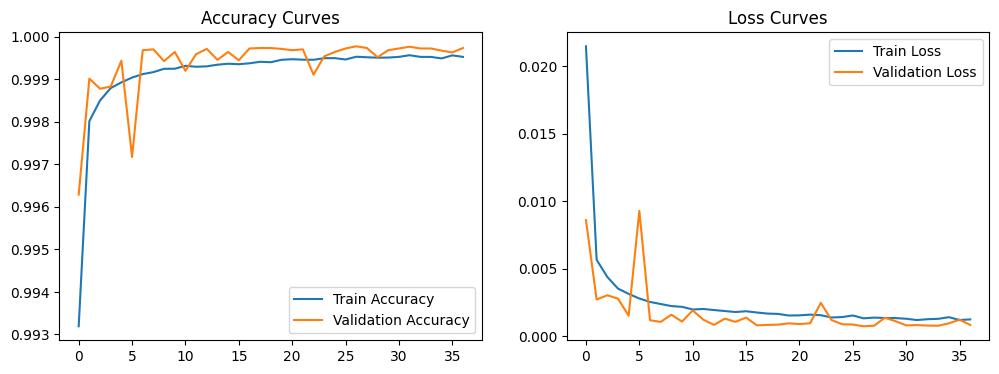

In [6]:
#DNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    # 2 hidded layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # 3 hidden layer
    Dense(64, activation='relu'),
    Dropout(0.2),

    # outlayer
    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [21]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import warnings
import lime
import lime.lime_tabular
warnings.filterwarnings('ignore')

def predict_proba(model, X):
    preds = model.predict(X)
    # 对于二分类，输出两列，每列是一个类别的概率
    proba = np.hstack([1 - preds, preds])  # 1 - preds 是第一个类别的概率，preds 是第二个类别的概率
    return proba

# 然后将模型的 predict_proba 方法设置为 predict_proba
model.predict_proba = lambda X: predict_proba(model, X)

def shap_plots(model, X_train, X_test, feature_names=None):
    """
    生成模型所有特征的整体SHAP条形图

    参数:
    model: 训练好的Keras模型
    X_train: 训练集特征数据
    X_test: 测试集特征数据
    feature_names: 特征名称列表，如果为None则自动生成
    """
    print("正在计算SHAP值并生成条形图...")
    print(f"特征数量: {X_train.shape[1]}")

    # 创建特征名称
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

    # 创建SHAP解释器 - 使用DeepExplainer对深度学习模型
    explainer = shap.Explainer(model, X_train[:100])  # 使用前100个样本作为背景数据

    # 计算测试集的SHAP值
    shap_values = explainer.shap_values(X_test[:1000])  # 计算前500个测试样本的SHAP值

    print(f"SHAP值形状: {shap_values.shape}")

    # 生成条形图
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test[:1000],
                     feature_names=feature_names,
                     plot_type="bar",
                     show=False,
                     max_display=min(20, len(feature_names)))  # 最多显示20个特征
    plt.title("SHAP Feature Importance - Bar Plot", fontsize=16, fontweight='bold')
    plt.xlabel("Mean |SHAP Value|", fontsize=12)
    plt.tight_layout()
    plt.show()

    print("条形图生成完成！")

    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test[:1000], feature_names=feature_names,show=False)
    plt.title("SHAP Feature Importance - Beeswarm Plot", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("蜂群图生成完成！")



def shap_waterfallplot_wrong_predictions(model, X_train, X_test, y_test, feature_names=None):
    """
    生成五个错误预测样本的SHAP瀑布图

    参数:
    model: 训练好的Keras模型
    X_train: 训练集特征数据
    X_test: 测试集特征数据
    y_test: 测试集真实标签
    feature_names: 特征名称列表，如果为None则自动生成
    """
    print("正在识别错误预测并生成瀑布图...")
    print(f"特征数量: {X_train.shape[1]}")

    # 创建特征名称
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

    # 获取模型预测 - 添加verbose=0减少输出
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # 确保y_test是numpy数组
    y_test_array = np.array(y_test).flatten()

    # 找到错误预测的索引
    wrong_indices = np.where(y_pred != y_test_array)[0]

    if len(wrong_indices) == 0:
        print("未发现错误预测！模型在测试集上表现完美。")
        return

    # 选择前5个错误预测（如果不足5个则全部选择）
    num_plots = min(5, len(wrong_indices))
    selected_indices = wrong_indices[:num_plots]

    print(f"发现 {len(wrong_indices)} 个错误预测，将展示前 {num_plots} 个的瀑布图")

    # 创建SHAP解释器
    explainer = shap.DeepExplainer(model, X_train[:100])

    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
                  X_train,
                  feature_names=feature_names,
                  class_names=le.classes_.tolist(),
                  mode='classification'
                  )

    # 为每个错误预测生成瀑布图
    for i, idx in enumerate(selected_indices):
        print(f"正在生成第 {i+1} 个错误预测的瀑布图...")

        try:
            # 计算单个样本的SHAP值
            sample_shap_values = explainer.shap_values(X_test[idx:idx+1])

            # 确保数据格式正确
            shap_vals = np.array(sample_shap_values).flatten()
            feature_vals = np.array(X_test[idx]).flatten()

            print(f"SHAP值数量: {len(shap_vals)}, 特征值数量: {len(feature_vals)}")

            # 获取预测信息
            true_label = int(y_test_array[idx])
            pred_proba = float(y_pred_proba[idx][0])
            pred_label = int(y_pred[idx])

            # 处理base_values
            base_val = float(explainer.expected_value)

            # 生成瀑布图
            plt.figure(figsize=(12, 8))

            # 创建Explanation对象用于瀑布图
            explanation = shap.Explanation(
                values=shap_vals,
                base_values=base_val,
                data=feature_vals,
                feature_names=feature_names
            )

            shap.waterfall_plot(explanation, show=False, max_display=10)
            plt.title(f"index #{idx} - true label: {true_label}, prediction: {pred_label}, prob: {pred_proba:.3f}",
                     fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            exp = explainer_lime.explain_instance(X_test[idx], model.predict_proba, num_features=10)
            exp.show_in_notebook(show_table=True)
        except Exception as e:
            print(f"生成第 {i+1} 个瀑布图时出错: {str(e)}")
            continue

    print("瀑布图生成完成！")


# 使用示例函数
def run_shap_analysis(model, X_train, X_test, y_test, feature_names=None):
    """
    运行完整的SHAP分析

    参数:
    model: 训练好的Keras模型
    X_train: 训练集特征数据
    X_test: 测试集特征数据
    y_test: 测试集真实标签
    feature_names: 特征名称列表，如果为None则自动生成
    """
    print("=" * 60)
    print("开始SHAP可解释性分析")
    print("=" * 60)

    # 1. 生成条形图
    print("\n1. 生成特征重要性...")
    shap_plots(model, X_train, X_test, feature_names)

    # 3. 生成错误预测的瀑布图
    print("\n3. 生成错误预测的瀑布图...")
    shap_waterfallplot_wrong_predictions(model, X_train, X_test, y_test, feature_names)

    print("\n" + "=" * 60)
    print("SHAP分析完成！")
    print("=" * 60)

# 使用方法:
# 确保已安装shap: pip install shap
#
# 如果您有特征名称列表：
feature_names = X.columns.to_list()  # 您的实际特征名称
#
# 调用单个函数:
# shap_barplots(model, X_train, X_test, feature_names)
# shap_beeswarmplot(model, X_train, X_test, feature_names)
# shap_waterfallplot_wrong_predictions(model, X_train, X_test, y_test, feature_names)
#
# 或运行完整分析:
run_shap_analysis(model, X_train, X_test, y_test, feature_names)
#
# 如果没有特征名称，会自动生成Feature_0, Feature_1等名称

Output hidden; open in https://colab.research.google.com to view.

In [18]:
def predict_proba(model, X):
    preds = model.predict(X)
    # 对于二分类，输出两列，每列是一个类别的概率
    proba = np.hstack([1 - preds, preds])  # 1 - preds 是第一个类别的概率，preds 是第二个类别的概率
    return proba

# 然后将模型的 predict_proba 方法设置为 predict_proba
model.predict_proba = lambda X: predict_proba(model, X)

explainer = lime.lime_tabular.LimeTabularExplainer(
                  X_train,
                  feature_names=feature_names,
                  class_names=le.classes_.tolist(),
                  mode='classification'
                  )
exp = explainer.explain_instance(X_test[7233], model.predict_proba, num_features=)
exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_clf = XGBClassifier(
    # objective='multi:softmax',
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric='logloss',
    early_stopping_rounds=10,
    scale_pos_weight=1
)

xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# evaluation
print("ROC AUC:", roc_auc_score(y_test, y_proba))
y_pred = xgb_clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC AUC: 0.9999989664364353
Confusion Matrix:
 [[ 95607     24]
 [    48 147457]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95631
           1       1.00      1.00      1.00    147505

    accuracy                           1.00    243136
   macro avg       1.00      1.00      1.00    243136
weighted avg       1.00      1.00      1.00    243136



In [ ]:
import shap
import numpy as np
import pandas as pd

# Solution 1: Use TreeExplainer instead of KernelExplainer (Recommended)
def shap_plots_fixed(model, X_train, X_test):
    """
    Fixed version using TreeExplainer which is more efficient and compatible
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test[:1000])

    # For binary classification, shap_values might be a list or 2D array
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    elif len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]  # Use positive class

    shap.summary_plot(shap_values, X_test[:1000], plot_type="bar")
    shap.summary_plot(shap_values, X_test[:1000])


def lime_plot(model, X_train, X_test,Y_train, row_index,class_names):
    import lime
    import lime.lime_tabular
    # Create a Lime explainer object
    explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    training_labels=Y_train,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    mode='classification'
    )

    exp = explainer.explain_instance(X_test.iloc[row_index], model.predict_proba, num_features=len(X_train.columns))
    exp.show_in_notebook(show_table=True)

def shap_waterfallplot_wrong_predictions_fixed(model, X_train, X_test, y_test,Y_train,class_names):
    """
    Fixed version for waterfall plots
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Get predictions
    y_pred = model.predict(X_test)

    # Find wrong predictions
    wrong_indices = np.where(y_pred != y_test)[0]

    if len(wrong_indices) == 0:
        print("No wrong predictions found!")
        return

    # Show waterfall plot for first wrong prediction
    num_plots = min(5, len(wrong_indices))
    selected_indices = wrong_indices[:num_plots]

    for i, idx in enumerate(selected_indices):
        print(f"Generating waterfall plot for index {idx}...")
        # Handle different shap_values formats
        if isinstance(shap_values, list):
            shap_vals = shap_values[1][idx]  # Use positive class
        elif len(shap_values.shape) == 3:
            shap_vals = shap_values[idx, :, 1]  # Use positive class
        else:
            shap_vals = shap_values[idx]

    # Create explanation object for waterfall plot
        explanation = shap.Explanation(
            values=shap_vals,
            base_values=explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
            data=X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
        )

        shap.waterfall_plot(explanation)
        lime_plot(model, X_train, X_test,Y_train, idx,class_names)


# Updated function calls - replace your original functions with these:
def run_shap_analysis(model, X_train, X_test, y_test,Y_train,class_names):
    """
    Run all SHAP analyses with fixed functions
    """
    print("Creating bar plots...")
    shap_plots_fixed(model, X_train, X_test)

    print("Creating waterfall plots for wrong predictions...")
    shap_waterfallplot_wrong_predictions_fixed(model, X_train, X_test, y_test,Y_train,class_names)

# Usage example:
class_names = le.classes_.tolist()
run_shap_analysis(xgb_clf, X_train, X_test, y_test,y_train,class_names)



Output hidden; open in https://colab.research.google.com to view.